In [54]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [55]:
# import data.
data = pd.read_csv('Cleaned_data_US_health_care.csv')

# set Id and rename columns
# data = data.reset_index()
data.columns = ['Id', 'Open_Date', 'Closed_Date']
# Open date - date at which customer started their service
# Clsoed date - date at which customer closed their service

# convert to datetime data type
data.Open_Date = pd.to_datetime(data.Open_Date)
data.Closed_Date = pd.to_datetime(data.Closed_Date)

# Start date and end date for churn_table
start_date = data.Open_Date.min()
end_date = data.Closed_Date.max()

# For still active customers, temporarily set their closed date to be a month in the future for computation.
data.Closed_Date = data.Closed_Date.fillna(end_date + datetime.timedelta(31))


In [56]:
print ('Data Start Date:', start_date)
print ('Data End Date:', end_date)

Data Start Date: 2016-01-10 00:00:00
Data End Date: 2017-12-11 00:00:00


In [57]:
def month_diff(a, b):
    # calculate the difference in two dates in month
    return (a.year - b.year)* 12 + (a.month - b.month)

def set_up_date():
    # set up date table
    end = []
    begin = []
    end_month=12
    for year in range(start_date.year+1, end_date.year+1):
        if year == end_date.year:
            end_month = end_date.month
        for month in range(1, end_month):
            begin.append(datetime.date(year, month, 1))
            if month == 12:
                end.append(datetime.date(year+1, 1, 1) - datetime.timedelta(days = 1))
            else:
                end.append(datetime.date(year, month+1, 1) - datetime.timedelta(days = 1))    
    date_table = pd.DataFrame([begin, end]).transpose()
    date_table.columns = ['begin', 'end']
    date_table['days'] = [(date_table.end[x] - date_table.begin[x]).days + 1 for x in range(len(date_table))]
    date_table.begin, date_table.end = pd.to_datetime(date_table.begin), pd.to_datetime(date_table.end)
    return date_table

In [58]:
set_up_date()

,begin,end,days
0,2017-01-01,2017-01-31,31
1,2017-02-01,2017-02-28,28
2,2017-03-01,2017-03-31,31
3,2017-04-01,2017-04-30,30
4,2017-05-01,2017-05-31,31
5,2017-06-01,2017-06-30,30
6,2017-07-01,2017-07-31,31
7,2017-08-01,2017-08-31,31
8,2017-09-01,2017-09-30,30
9,2017-10-01,2017-10-31,31


In [59]:
def get_churn_table():
    # Calculate Customer Churn
    churn =set_up_date()
    list_ = []
    for i in range(len(churn)):
        # Customers at the beginning of month
        id_beg = data.loc[(data['Open_Date'] <= churn.begin[i]) & (data['Closed_Date'] >= churn.begin[i]), 'Id']
        # Customers at the end of month
        id_end = data.loc[(data['Open_Date'] <= churn.end[i]) & (data['Closed_Date'] >= churn.end[i]), 'Id']   
        # Customers left during the month
        id_close =  data.loc[(data['Closed_Date'] >= churn.begin[i]) & (data['Closed_Date'] <= churn.end[i]), 'Id']
        # Customers left during the month (Those who were already customers before this month)
        id_beg_close = data.loc[(data.Id.isin(id_beg)) & (data.Id.isin(id_close)), 'Id']
        # Customers left during the month (Those who joined and left during the month)
        id_during = data.loc[(data['Closed_Date'] >= churn.begin[i]) & (data['Closed_Date'] <= churn.end[i])  & \
                                     (data['Open_Date'] >= churn.begin[i]) & (data['Open_Date'] <= churn.end[i]), 'Id']               
        # Customers joined during the month.
        id_app = data.loc[(data['Open_Date'] >= churn.begin[i]) & (data['Open_Date'] <= churn.end[i]), 'Id']
        
        # Calculate days between customer's start date and end of month (customers who started this month)
        if len(id_app)> 0:
            id_app_days = (churn.end[i] - data.loc[data.Id.isin(id_app), 'Open_Date']).sum().days
        else:
            id_app_days = 0

        # Calculate days between customer's closed date and end of month (customers who left this month)            
        if len(id_close)> 0:
            id_close_days = (churn.end[i] - data.loc[data.Id.isin(id_close), 'Closed_Date']).sum().days
        else:
            id_close_days = 0    
        
        # Sum of active customers in each day.
        total_days = churn.days[i]*len(data.loc[(data.Id.isin(id_beg)) & (data.Id.isin(id_close)==False), 'Id']) + \
                        id_app_days -  id_close_days
        list_.append((len(id_beg), len(id_end), len(id_close), len(id_beg_close), 
                      len(id_app), len(id_during), total_days))
    list_ = pd.DataFrame(list_)
    list_.columns = ['Customers_at_BOM', 'Customers_at_EOM', 'Customers_Lost', 'Customers_Lost_from_last_month',
                     'Customers_Added', 'Customers_within_month_churn', 'Total_Days']
    for col in list_.columns:
        list_[col] = list_[col].astype(float)
    churn = pd.concat([churn, list_], axis = 1)
    return churn    

In [60]:
churn = get_churn_table()

In [65]:
# churn['churn_rate_by_daily_rate'] = (churn.days*(churn.Customers_Lost/churn.Total_Days)).fillna(0)
churn = churn.set_index(pd.DatetimeIndex(churn.end))

churn['churn_rate_by_EOM'] = churn.Customers_Lost/churn.Customers_at_BOM
churn['churn_rate_by_BOM'] = churn.Customers_Lost/churn.Customers_at_BOM
churn['demand_rate_by_EOM'] = churn.Customers_Added/churn.Customers_at_BOM
churn['demand_rate_by_BOM'] = churn.Customers_Added/churn.Customers_at_BOM

In [66]:
churn

,begin,end,days,Customers_at_BOM,Customers_at_EOM,Customers_Lost,Customers_Lost_from_last_month,Customers_Added,Customers_within_month_churn,Total_Days,churn_rate_by_EOM,churn_rate_by_BOM,demand_rate_by_EOM,demand_rate_by_BOM
end,,,,,,,,,,,,,,
2017-01-31,2017-01-01,2017-01-31,31,1489.0,4251.0,2685.0,592.0,5048.0,1445.0,93776.0,1.803224,1.803224,3.390195,3.390195
2017-02-28,2017-02-01,2017-02-28,28,4250.0,5260.0,2519.0,830.0,2819.0,963.0,108721.0,0.592706,0.592706,0.663294,0.663294
2017-03-31,2017-03-01,2017-03-31,31,5148.0,5750.0,3142.0,1146.0,3024.0,1293.0,129623.0,0.610334,0.610334,0.587413,0.587413
2017-04-30,2017-04-01,2017-04-30,30,5617.0,5869.0,2548.0,1014.0,2377.0,945.0,140770.0,0.453623,0.453623,0.423180,0.423180
2017-05-31,2017-05-01,2017-05-31,31,5781.0,5896.0,2698.0,1143.0,2434.0,1006.0,143680.0,0.466701,0.466701,0.421034,0.421034
2017-06-30,2017-06-01,2017-06-30,30,5775.0,5764.0,2908.0,1389.0,2647.0,1067.0,133451.0,0.503550,0.503550,0.458355,0.458355
2017-07-31,2017-07-01,2017-07-31,31,5492.0,5315.0,2627.0,1307.0,2445.0,960.0,130655.0,0.478332,0.478332,0.445193,0.445193
2017-08-31,2017-08-01,2017-08-31,31,5093.0,4789.0,2612.0,1387.0,2308.0,930.0,115357.0,0.512861,0.512861,0.453171,0.453171
2017-09-30,2017-09-01,2017-09-30,30,4536.0,3866.0,2671.0,1630.0,2259.0,851.0,85906.0,0.588845,0.588845,0.498016,0.498016


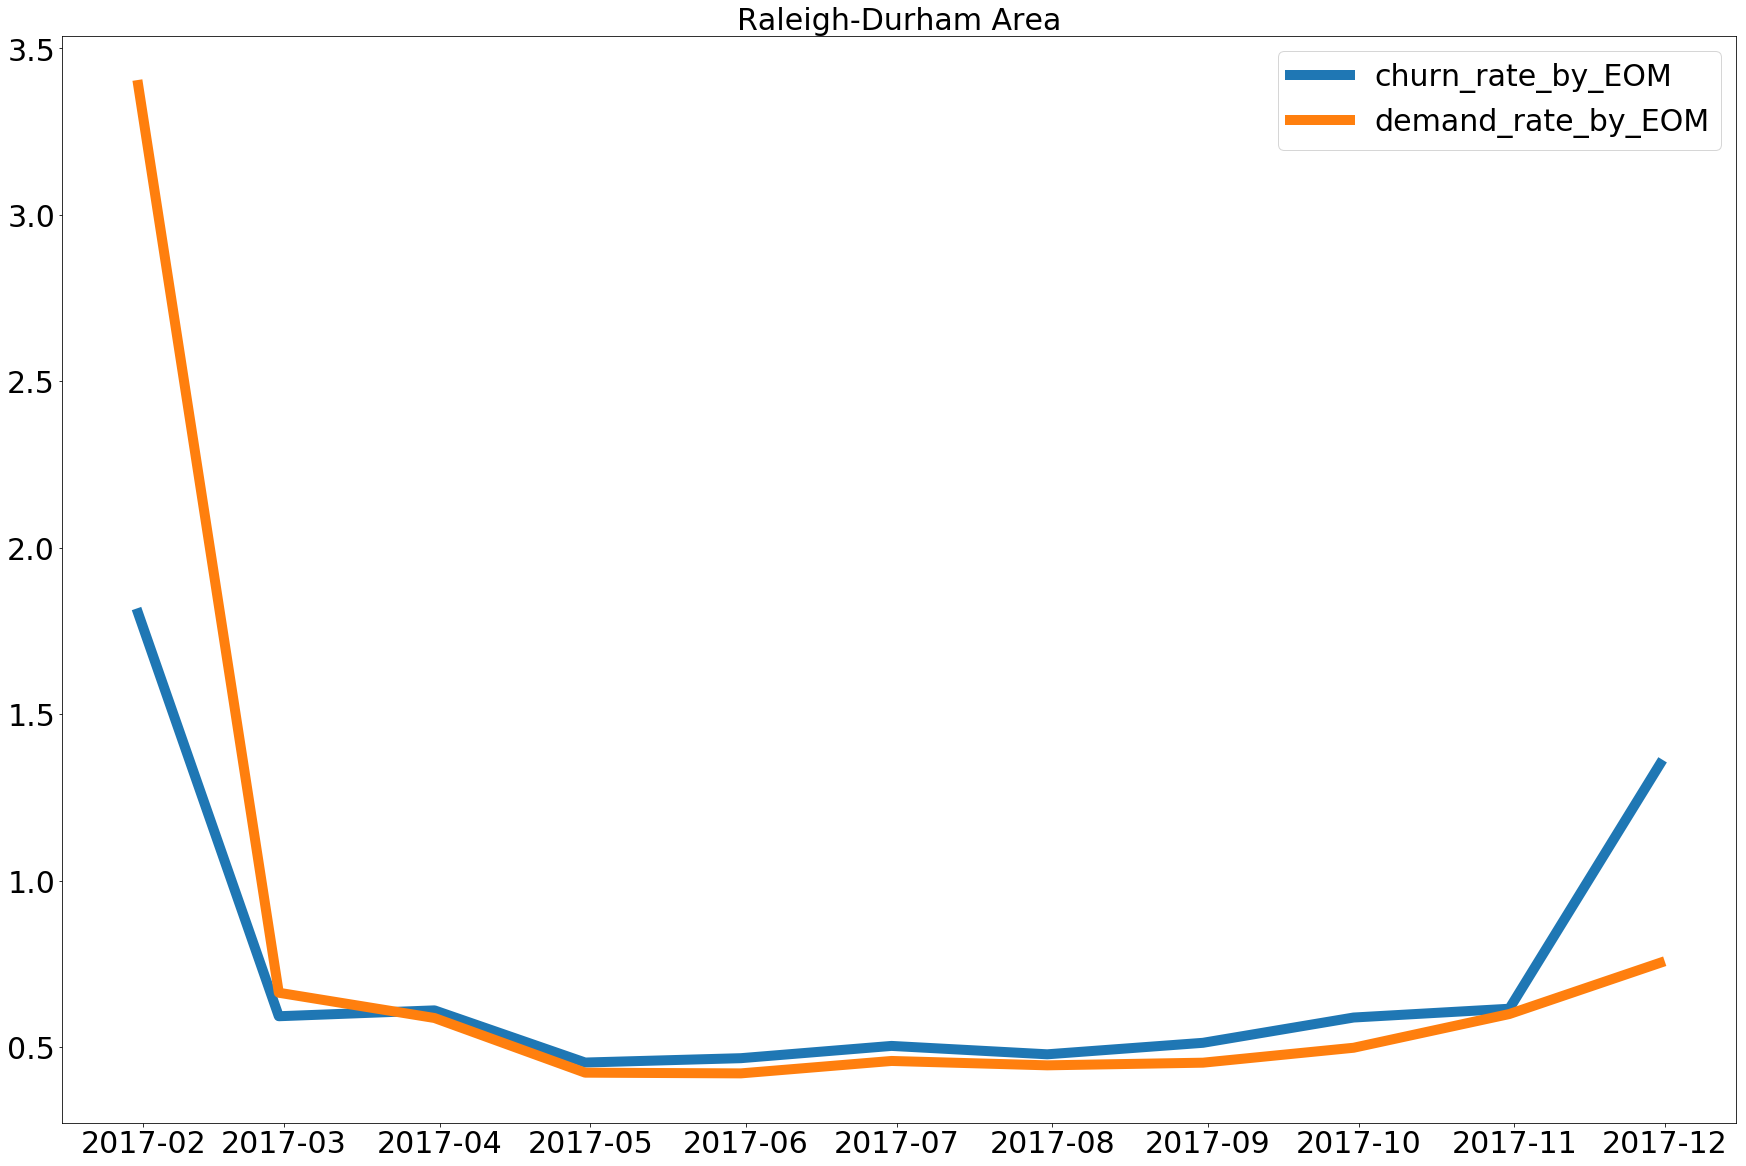

In [67]:
plt.figure(figsize = (30, 20))
for col in ['churn_rate_by_EOM', 'demand_rate_by_EOM',]:
    plt.plot(churn[col], linewidth=10)
plt.legend(prop={'size':30})
plt.title('Raleigh-Durham Area', size=30)
plt.tick_params(labelsize=30)
plt.show()

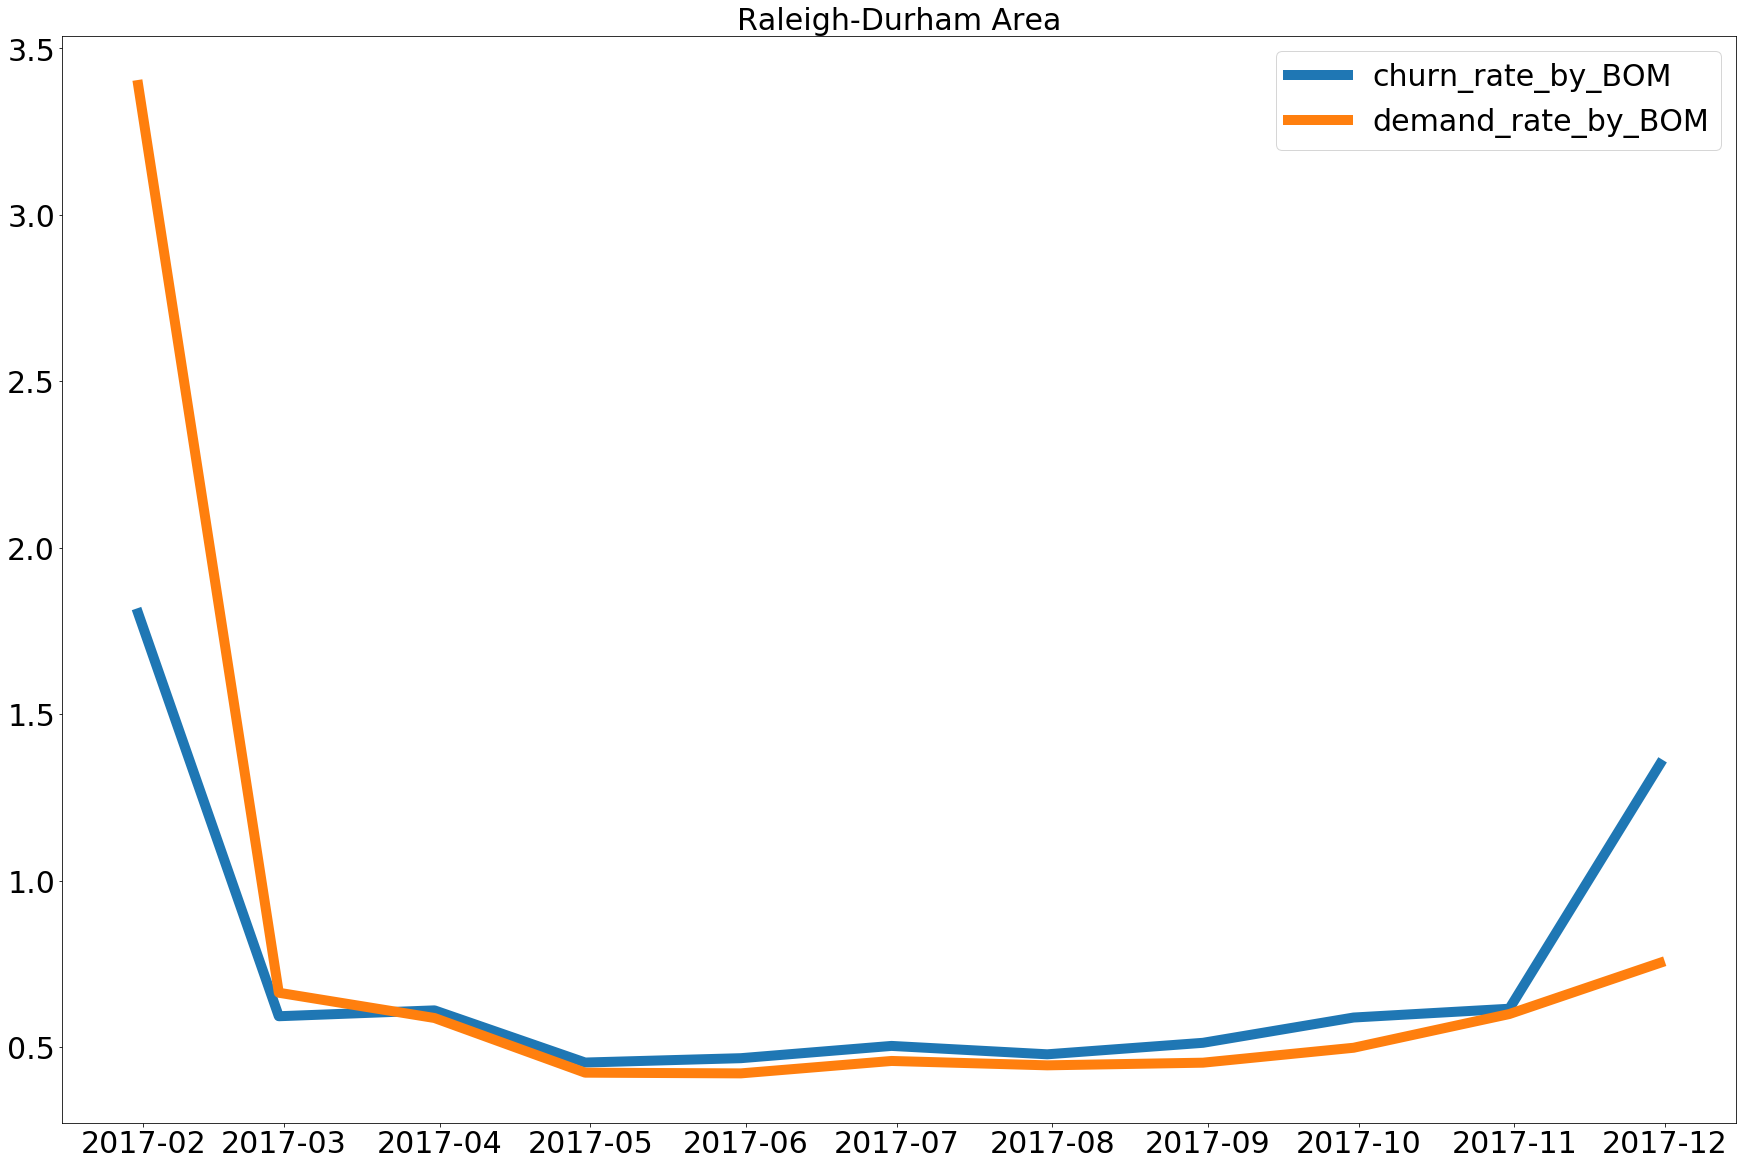

In [68]:
plt.figure(figsize = (30, 20))
for col in ['churn_rate_by_BOM', 'demand_rate_by_BOM',]:
    plt.plot(churn[col], linewidth=10)
plt.legend(prop={'size':30})
plt.title('Raleigh-Durham Area', size=30)
plt.tick_params(labelsize=30)
plt.show()